In [459]:
from math import floor

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import TweedieRegressor, GammaRegressor 
from sklearn import tree # https://scikit-learn.org/stable/modules/tree.html

# A very easy to follow tutorial for exactly what we're doing!
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_tweedie_regression_insurance_claims.html#sphx-glr-auto-examples-linear-model-plot-tweedie-regression-insurance-claims-py


In [300]:
# Some very nice functions I found in the tutorial linked above

def plot_obs_pred(df, feature, weight, observed, predicted, y_label=None,
                  title=None, ax=None, fill_legend=False):
    """Plot observed and predicted - aggregated per feature level.

    Remember to declare figure first with the below;
        fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16, 8))
        fig.subplots_adjust(hspace=0.3, wspace=0.2)       
        
    Parameters
    ----------
    df : DataFrame
        input data
    feature: str
        a column name of df for the feature to be plotted
    weight : str
        column name of df with the values of weights or exposure
    observed : str
        a column name of df with the observed target
    predicted : DataFrame
        a dataframe, with the same index as df, with the predicted target
    fill_legend : bool, default=False
        whether to show fill_between legend
    """
    # aggregate observed and predicted variables by feature level
    df_ = df.loc[:, [feature, weight]].copy()
    df_["observed"] = df[observed] * df[weight]
    df_["predicted"] = predicted * df[weight]
    df_ = (
        df_.groupby([feature])[[weight, "observed", "predicted"]]
        .sum()
        .assign(observed=lambda x: x["observed"] / x[weight])
        .assign(predicted=lambda x: x["predicted"] / x[weight])
    )

    ax = df_.loc[:, ["observed", "predicted"]].plot(style=".", ax=ax)
    y_max = df_.loc[:, ["observed", "predicted"]].values.max() * 0.8
    p2 = ax.fill_between(
        df_.index,
        0,
        y_max * df_[weight] / df_[weight].values.max(),
        color="g",
        alpha=0.1,
    )
    if fill_legend:
        ax.legend([p2], ["{} distribution".format(feature)])
    ax.set(
        ylabel=y_label if y_label is not None else None,
        title=title if title is not None else "Train: Observed vs Predicted",
    )

def score_estimator(estimator, X_train, X_test, df_train, df_test, target, weights,
    tweedie_powers=None):

    """Evaluate an estimator on train and test sets with different metrics"""

    metrics = [
        ("D² explained", None),   # Use default scorer if it exists
        ("mean abs. error", mean_absolute_error),
        ("mean squared error", mean_squared_error),
    ]
    if tweedie_powers:
        metrics += [(
            "mean Tweedie dev p={:.4f}".format(power),
            partial(mean_tweedie_deviance, power=power)
        ) for power in tweedie_powers]

    res = []
    for subset_label, X, df in [
        ("train", X_train, df_train),
        ("test", X_test, df_test),
    ]:
        y, _weights = df[target], df[weights]
        for score_label, metric in metrics:
            if isinstance(estimator, tuple) and len(estimator) == 2:
                # Score the model consisting of the product of frequency and
                # severity models.
                est_freq, est_sev = estimator
                y_pred = est_freq.predict(X) * est_sev.predict(X)
            else:
                y_pred = estimator.predict(X)

            if metric is None:
                if not hasattr(estimator, "score"):
                    continue
                score = estimator.score(X, y, sample_weight=_weights)
            else:
                score = metric(y, y_pred, sample_weight=_weights)

            res.append(
                {"subset": subset_label, "metric": score_label, "score": score}
            )

    res = (
        pd.DataFrame(res)
        .set_index(["metric", "subset"])
        .score.unstack(-1)
        .round(4)
        .loc[:, ['train', 'test']]
    )
    return res

def get_dummies(series):
    '''
    Get Dummies

    This one is mine, it tried to 'one hot' encode the categorical variables.
    '''
    dummyframe = pd.DataFrame()
    name = series.name
    for x in series.unique():
        dummyframe[f"{name}_{x}"] = [1 if item == x else 0 for item in series]
    return dummyframe

In [308]:
raw_data = pd.read_csv(r"C:\Users\Dev Work\Documents\aicrowd\insurancepricing\python\training.csv")

raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228216 entries, 0 to 228215
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id_policy               228216 non-null  object 
 1   year                    228216 non-null  int64  
 2   pol_no_claims_discount  228216 non-null  float64
 3   pol_coverage            228216 non-null  object 
 4   pol_duration            228216 non-null  int64  
 5   pol_sit_duration        228216 non-null  int64  
 6   pol_pay_freq            228216 non-null  object 
 7   pol_payd                228216 non-null  object 
 8   pol_usage               228216 non-null  object 
 9   drv_sex1                228216 non-null  object 
 10  drv_age1                228216 non-null  int64  
 11  drv_age_lic1            228216 non-null  int64  
 12  drv_drv2                228216 non-null  object 
 13  drv_sex2                228216 non-null  object 
 14  drv_age2            

In [390]:
# Data Preprocessing
raw_data = pd.read_csv(r"C:\Users\Dev Work\Documents\aicrowd\insurancepricing\python\training.csv")

# Bools
raw_data['drv_drv2'] = [1 if x == 'Yes' else 0 for x in raw_data['drv_drv2']]

# label encoding
# keep the dummy frames for later, we can use .columns to get a list of one hot column names easily.
dummy_pol_coverage = get_dummies(raw_data['pol_coverage'])
dummy_pol_pay_freq = get_dummies(raw_data['pol_pay_freq'])
dummy_pol_usage    = get_dummies(raw_data['pol_usage'])
dummy_drv_sex1     = get_dummies(raw_data['drv_sex1'])

raw_data = raw_data.join(dummy_pol_coverage)
raw_data = raw_data.join(dummy_pol_pay_freq)
raw_data = raw_data.join(dummy_pol_usage)
raw_data = raw_data.join(dummy_drv_sex1)

# Here we create the datasets themselves
policies_with_claims = raw_data['claim_amount'] > 0
data = raw_data[policies_with_claims]

claims_minor = data[(data['claim_amount'] >= 60) & (data['claim_amount'] < 160)]
claims_major = data[(data['claim_amount'] >= 160) & (data['claim_amount'] < 8000)]
claims_ultra = data[data['claim_amount'] >= 8000]

In [391]:
raw_data

,id_policy,year,pol_no_claims_discount,pol_coverage,pol_duration,pol_sit_duration,pol_pay_freq,pol_payd,pol_usage,drv_sex1,...,pol_pay_freq_Monthly,pol_pay_freq_Yearly,pol_pay_freq_Quarterly,pol_pay_freq_Biannual,pol_usage_WorkPrivate,pol_usage_Retired,pol_usage_Professional,pol_usage_AllTrips,drv_sex1_M,drv_sex1_F
0,PL000000,1,0.332,Med2,5,1,Monthly,No,WorkPrivate,M,...,1,0,0,0,1,0,0,0,1,0
1,PL042495,1,0.000,Med2,6,1,Monthly,No,WorkPrivate,M,...,1,0,0,0,1,0,0,0,1,0
2,PL042496,1,0.196,Med1,2,1,Yearly,Yes,Retired,M,...,0,1,0,0,0,1,0,0,1,0
3,PL042497,1,0.000,Med2,8,5,Yearly,No,WorkPrivate,F,...,0,1,0,0,1,0,0,0,0,1
4,PL042498,1,0.000,Med1,2,2,Yearly,No,Retired,F,...,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228211,PL008818,4,0.087,Med2,4,4,Monthly,No,WorkPrivate,F,...,1,0,0,0,1,0,0,0,0,1
228212,PL055033,4,0.000,Max,14,5,Monthly,No,WorkPrivate,M,...,1,0,0,0,1,0,0,0,1,0
228213,PL061619,4,0.181,Max,10,4,Yearly,No,Retired,F,...,0,1,0,0,0,1,0,0,0,1
228214,PL060903,4,0.000,Max,25,15,Biannual,No,Professional,M,...,0,0,0,1,0,0,1,0,1,0


In [311]:
data.head()

,id_policy,year,pol_no_claims_discount,pol_coverage,pol_duration,pol_sit_duration,pol_pay_freq,pol_payd,pol_usage,drv_sex1,...,pol_coverage_Max,pol_coverage_Min,pol_pay_freq_Monthly,pol_pay_freq_Yearly,pol_pay_freq_Quarterly,pol_pay_freq_Biannual,pol_usage_WorkPrivate,pol_usage_Retired,pol_usage_Professional,pol_usage_AllTrips
14,PL042479,1,0.000,Max,5,2,Biannual,No,WorkPrivate,M,...,1,0,0,0,0,1,1,0,0,0
15,PL042480,1,0.000,Max,27,3,Yearly,No,Retired,F,...,1,0,0,1,0,0,0,1,0,0
20,PL042488,1,0.428,Med2,4,4,Biannual,No,Retired,M,...,0,0,0,0,0,1,0,1,0,0
31,PL042548,1,0.000,Max,2,2,Biannual,No,Professional,F,...,1,0,0,0,0,1,0,0,1,0
45,PL042474,1,0.000,Max,26,2,Biannual,No,WorkPrivate,F,...,1,0,0,0,0,1,1,0,0,0


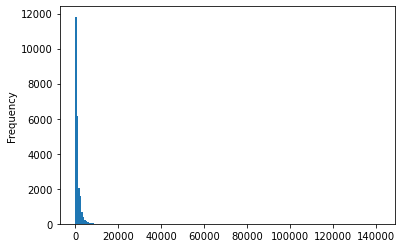

In [312]:
data['claim_amount'].plot(kind="hist", bins=200)

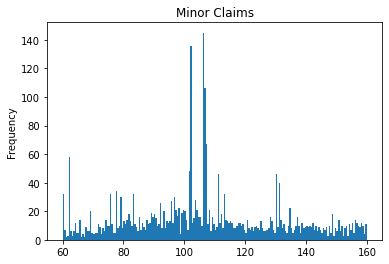

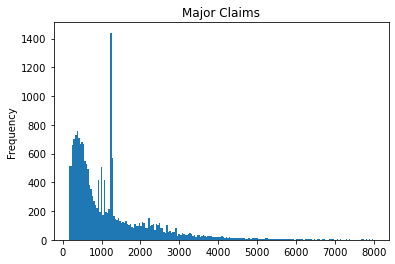

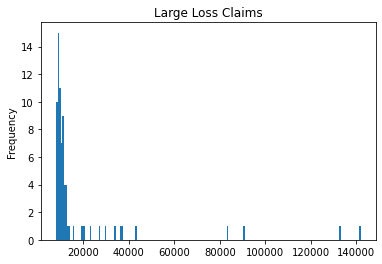

In [314]:
claims_minor['claim_amount'].plot(kind="hist", bins=200, title="Minor Claims")
plt.show()
claims_major['claim_amount'].plot(kind="hist", bins=200, title="Major Claims")
plt.show()
claims_ultra['claim_amount'].plot(kind="hist", bins=200, title="Large Loss Claims")
plt.show()

In [404]:
from sklearn.model_selection import train_test_split

class ClaimModel():
    '''
    Helper class to keep track of model attributes and datasets. Inputs; model, dataset, target, features.

    '''
    
    def __init__(self, model, dataset, target=None, features=None):
        

        self.model = model
        self.dataset = dataset
        self.features = features
        self.target = target

        self._y = dataset[target]
        self._x = dataset[features]

        self.splitData()

    def splitData(self):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self._x, self._y)
        self._train_index = self.x_train.index
        self._test_index = self.x_test.index
        self.train = self.dataset[self.dataset.index.isin(self._train_index)]
        self.test = self.dataset[self.dataset.index.isin(self._test_index)]

    def fit(self, *args, **kwargs):
        self.model.fit(self.x_train, self.y_train, *args, **kwargs)
    
    def predict(self, *args, **kwargs):
        self.predictions = self.model.predict(self.x_test, *args, **kwargs)
        self.results = pd.DataFrame({
                            "Actual":self.y_test, 
                            "Predictions":self.predictions,
                            "Residuals":self.predictions - self.y_test,
                            "Residuals_Squared":((self.predictions - self.y_test)**2)**0.5
                            })
        return self.predictions

    def plot(self,**kwargs):
        plot_obs_pred(df=self.test, predicted=self.predict(), **kwargs)


In [350]:
minor_model = TweedieRegressor(power=0, link='log')
major_model = GammaRegressor(alpha=10.,max_iter=10000)
ultra_model = TweedieRegressor(power=2, link='log')

features = ['pol_sit_duration', 'pol_duration', 'drv_age1', 'drv_drv2']

features = [*features, *dummy_pol_coverage.columns]
features = [*features, *dummy_pol_pay_freq.columns]
features = [*features, *dummy_pol_usage.columns]
features = [*features, *dummy_drv_sex1.columns]

minor = ClaimModel(minor_model, claims_minor, target='claim_amount', features=features)
major = ClaimModel(major_model, claims_major, target='claim_amount', features=features)
ultra = ClaimModel(ultra_model, claims_ultra, target='claim_amount', features=features)

models = [major]

In [351]:
for model in models:
    model.fit()
    model.predict()

    model.results

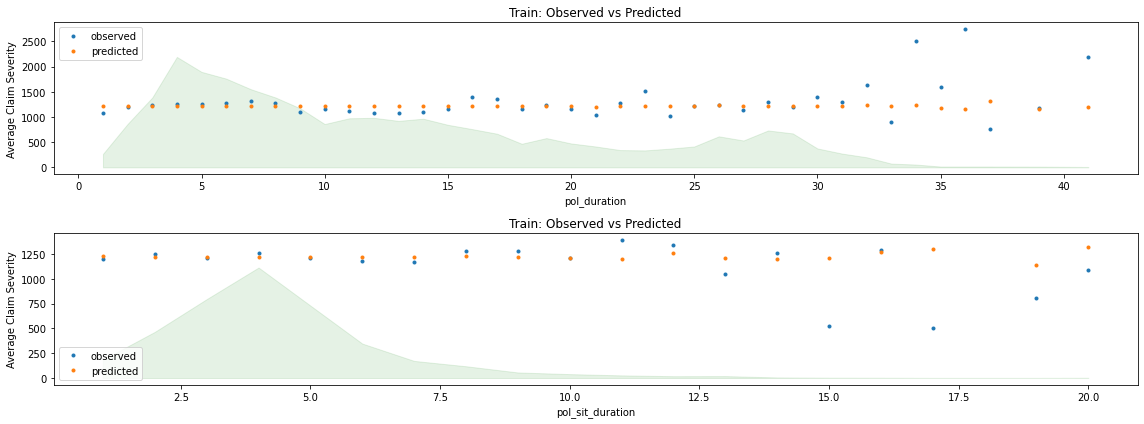

In [339]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(16, 6))

major.plot(feature="pol_duration",
    weight="year",
    observed="claim_amount",
    y_label="Average Claim Severity",
    ax=ax[0])

major.plot(feature="pol_sit_duration",
    weight="year",
    observed="claim_amount",
    y_label="Average Claim Severity",
    ax=ax[1])

plt.tight_layout()

(array([11., 14.,  9.,  9., 12., 14., 18., 26., 35., 29., 44., 35., 37.,
        26., 27., 15.,  6., 13.,  5.,  5.,  5.,  1.,  4.,  1.,  4.,  0.,
         1.,  1.,  2.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([   7.62297048,   73.20605074,  138.78913101,  204.37221127,
         269.95529154,  335.5383718 ,  401.12145206,  466.70453233,
         532.28761259,  597.87069285,  663.45377312,  729.03685338,
         794.61993364,  860.20301391,  925.78609417,  991.36917443,
        1056.9522547 , 1122.53533496, 1188.11841523, 1253.70149549,
        1319.28457575, 1384.86765602, 1450.45073628, 1516.03381654,
        1581.61689681, 164

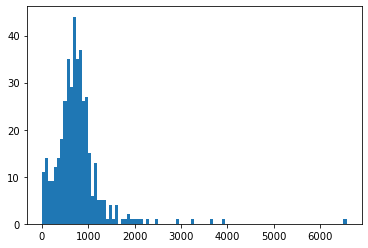

In [393]:
plt.hist(major.test.join(major.results).groupby('vh_make_model')['Residuals_Squared'].mean(), bins=100)

In [496]:
# A new dataframe with residual data from past models
major_with_vh_dataset = major.test.join(major.results)[['vh_make_model', 'claim_amount','Predictions', 'Residuals', 'Residuals_Squared']]

# Data processing
major_with_vh_dataset.reset_index(inplace=True, drop=True)

# One hot encoding the make/model strings
dummy_vh_make_model = get_dummies(major_with_vh_dataset['vh_make_model'])
major_with_vh_dataset = major_with_vh_dataset.join(dummy_vh_make_model)

# Classifying the residual column
# To round to nearest 1 to try and force multiclass y
major_with_vh_dataset['Residuals_classed'] = [int(x) for x in major_with_vh_dataset['Residuals']]

features = [*dummy_vh_make_model.columns]



In [502]:
major_with_vh_model = tree.DecisionTreeClassifier()
major_with_vh = ClaimModel( major_with_vh_model, major_with_vh_dataset, target='Residuals_classed', features=features)

major_with_vh.fit()
major_with_vh.predict()
major_with_vh.results.mean()

Actual                 20.930233
Predictions         -1062.406576
Residuals           -1083.336808
Residuals_Squared    1821.814755
dtype: float64

In [503]:
major_with_vh.results.head(50)

,Actual,Predictions,Residuals,Residuals_Squared
413,532,904,372,372.0
1318,303,62,-241,241.0
2088,764,785,21,21.0
3993,9,0,-9,9.0
1519,-80,-2647,-2567,2567.0
1167,-1272,0,1272,1272.0
1248,-441,445,886,886.0
3444,-3314,695,4009,4009.0
3201,-5408,-99,5309,5309.0
4024,-1636,-1132,504,504.0
